In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [2]:
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = models.vgg19(pretrained=True).to(device)
model.eval()

# Why do we have model.eval()?
# It is because we are testing / visualizing the model, not training it.
# So we need to set it in eval mode to 
# turn off dropout
# Use running statistics in batch normalization layers 

c:\Anaconda3\envs\models\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Anaconda3\envs\models\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# Helper function to show the image tensor

def show_tensor_image(tensor, title="", scale=1.0):
    # clamp to [0,1] just in case
    tensor = tensor.detach().cpu().clamp(0,1)
    # shape: [3, H, W]
    img_np = tensor.permute(1,2,0).numpy()
    
    plt.figure(figsize=(4*scale,4*scale))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [6]:
# HELPER - Activation Hook
# ======================================
# We'll define a function to register a forward hook 
# to capture a layer's output for layer-based activation.

activation = None
def hook_fn(layer, input, ouput):
    global activation
    activation = ouput  # store the output of this layer # We do not need a return statement here
    # output shape: [batch_size, num_channels, height, width]

def register_hook_for_layer(layer_idx):
    """ Register a forward hook for VGG19 at the given layer index. """
    global activation
    activation = None  # reset
    # vgg16 has model.features which is a sequential container
    target_module = model.features[layer_idx]
    return target_module.register_forward_hook(hook_fn)

In [7]:
#  OPTIONAL: Total Variation Loss
def total_variation_loss(x):
    """
    Simple total variation loss for image smoothing.
    x shape: [1, 3, H, W]
    """
    # Shift by 1 pixel and take difference in both x and y directions
    diff_x = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
    diff_y = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
    return diff_x + diff_y

In [8]:
# CASE A - LAYER/FILTER MAXIMIZATION
# ======================================

def activation_maximize_filter(layer_idx=10, filter_idx=5,
                               steps=50, lr=0.05, tv_weight=0.0, show_every=10):
    """
    Maximize the activation of (filter_idx) in the convolutional layer (layer_idx).
    """
    # 1) Register hook
    hook_handle = register_hook_for_layer(layer_idx)

    # 2) Create a random image
    img_size = 224
    input_img = torch.randn(1, 3, img_size, img_size, requires_grad=True, device=device)

    # 3) Define optimizer
    optimizer = optim.Adam([input_img], lr=lr)

    for step in range(steps):

        optimizer.zero_grad()

        # forward pass
        model(input_img)

        # activation shape: [batch, num_filters, height, width]
        # For example, if you pass a single image (batch size = 1) into a convolutional layer that outputs 256 feature maps and each feature map is 28×28, then the activation tensor would be shaped as:
        # [1, 256, 28, 28]
        # we want a single filter => activation[0, filter_idx, :, :]
        filter_act = activation[0, filter_idx, :, :]
        act_loss = -filter_act.mean()  # negative, so we maximize
        # standard optimization in PyTorch minimizes a loss function
        # Objective: We want the average activation (i.e. the mean of all values in the 2D activation map for that filter) to be as high as possible.
        # So we minimize the negative of the average activation.

        # optional total variation loss
        tv_loss = 0
        if tv_weight > 0:
            tv_loss = tv_weight * total_variation_loss(input_img)

        loss = act_loss + tv_loss

        loss.backward()
        optimizer.step()

        # Optionally clamp or scale
        with torch.no_grad():
            input_img.clamp_(0,1)  # keep image in [0,1]

        # Display partial results
        if step % show_every == 0:
            clear_output(wait=True)
            print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")
            show_tensor_image(input_img[0], title=f"Layer {layer_idx}, Filter {filter_idx}, step={step}")

    hook_handle.remove()
    return input_img

Step 90/100, Loss: -45.1046


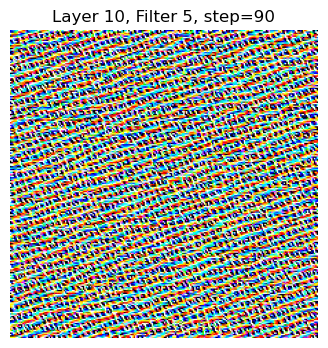

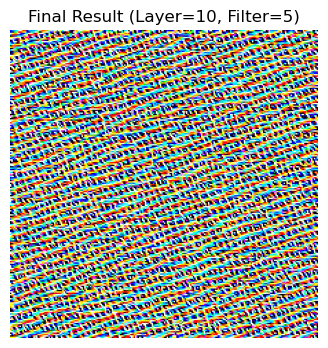

In [9]:
# Let's do a quick run
max_img = activation_maximize_filter(layer_idx=10, filter_idx=5,
                                     steps=100, lr=0.05, tv_weight= 1e-3, show_every=10)
show_tensor_image(max_img[0], title="Final Result (Layer=10, Filter=5)")

In [13]:
# CASE B - CLASS LOGIT MAXIMIZATION
# ======================================
# For class-based visualization, we don't need a special hook,
# because we can directly index the final output logit.

def activation_maximize_class(class_idx=207, steps=50, lr=0.05, tv_weight= 1e-3, show_every=10):
    """
    Maximize the logit for a specific class index in the final classification layer.
    class_idx=207 is 'golden retriever' if we have standard ImageNet indexing.
    """
    # Create random input
    img_size = 224
    input_img = torch.randn(1, 3, img_size, img_size, requires_grad=True, device=device)

    # We'll do gradient ascent on the logit for the chosen class
    optimizer = optim.Adam([input_img], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()

        # forward pass
        out = model(input_img)  # shape: [1, 1000] for VGG16
        # we pick the logit for class_idx
        logit = out[0, class_idx]
        loss = -logit  # negative => we want to maximize the logit

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            input_img.clamp_(0,1)

        # partial display
        if step % show_every == 0:
            clear_output(wait=True)
            class_name = classes[class_idx] if classes else f"class {class_idx}"
            print(f"Step {step}/{steps}, Loss: {loss.item():.4f}, Class={class_name}")
            show_tensor_image(input_img[0], title=f"{class_name}, step={step}")

    return input_img


Step 190/200, Loss: -581.6338, Class=golden retriever


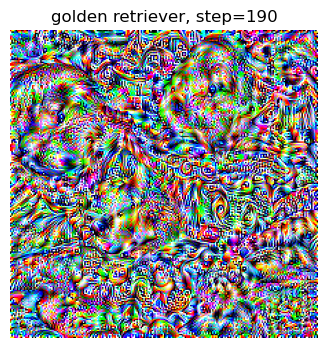

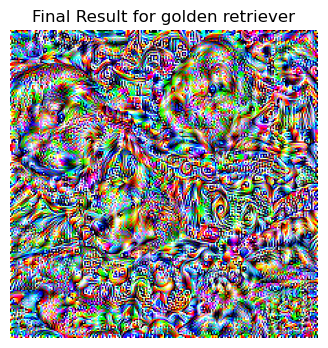

In [18]:
final_img = activation_maximize_class(class_idx=207, steps=200, lr=0.05, tv_weight= 1e-3, show_every=10)
class_name = classes[207] if classes else "class 207"
show_tensor_image(final_img[0], title=f"Final Result for {class_name}")